In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score , median_absolute_error, mean_absolute_error
import shap
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance





Pour tenter de predire les variables TotalGHEEmission et SourceEUI nous allons mettre en place 5 modèles d'aprentissage supérvisé:
Un modèle de régréssion linéaire qui nous servira de baseline
Deux modèles linéaire (ElasticNet et Support Vector Regressor)
Deux modèles d'arbres de décision (RandomForest et Xgboost)

Chaque modèle sera entrainé en GridSearch sur different paramètres et nous verifieront les résultats avec trois métrique:
Le r2
la mean absolute error 
et la mean squared error

De plus nous entraineront nos modèles sur 2 Set de données , l'un contenant la variable ENERGYSTARScore et l'autre non, cela permettra de conclure sur l'importance de cette variable pour nos prédictions, cependant pour eviter de surcharger ce Notebook l'entrainement du set donnée sans ENERGYSTARScore n'apparait pas et nous chargerons simplement les résultats.

In [2]:
noES_EUI_test_results=pd.read_csv('EUI_test_results.csv',sep='\t')
noES_GHG_test_results=pd.read_csv('GHG_test_results.csv',sep='\t')
noES_GHG_results=pd.read_csv('GHG_results.csv',sep='\t')
noES_EUI_results=pd.read_csv('EUI_results.csv',sep='\t')

In [3]:
energy=pd.read_csv('energy_clean.csv',sep='\t')

In [4]:
energy

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),SecondLargestPropertyUseType,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,1,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1927,12.0,7369.500000,100.000000,HOTEL,65.0,5.161925,1,1,5.523179
1,2,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1996,11.0,9415.090909,85.454686,PARKING,51.0,5.259057,0,1,5.577879
2,3,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1969,41.0,23463.170732,100.000000,PARKING,18.0,5.495938,1,1,7.631664
3,5,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1926,10.0,6132.000000,100.000000,HOTEL,1.0,6.457241,1,1,7.569071
4,8,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1980,18.0,6660.555556,89.607140,PARKING,67.0,5.437209,0,1,6.231858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,50069,2016,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,2,GREATER DUWAMISH,1929,2.0,12495.000000,100.000000,SMALL- AND MID-SIZED OFFICE,9.0,5.908083,0,1,4.911183
2201,50081,2016,NONRESIDENTIAL,K-12 SCHOOL,3,GREATER DUWAMISH,2015,3.0,15000.000000,100.000000,PARKING,77.0,4.522875,0,0,2.326302
2202,50210,2016,NONRESIDENTIAL COS,OFFICE,7,MAGNOLIA / QUEEN ANNE,1952,1.0,13661.000000,100.000000,OFFICE,75.0,4.757891,0,0,1.504077
2203,50220,2016,NONRESIDENTIAL COS,OFFICE,2,SOUTHEAST,1960,1.0,15398.000000,100.000000,OFFICE,93.0,4.175925,0,1,2.173615


In [5]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 2205 non-null   int64  
 1   DataYear                      2205 non-null   int64  
 2   BuildingType                  2205 non-null   object 
 3   PrimaryPropertyType           2205 non-null   object 
 4   CouncilDistrictCode           2205 non-null   int64  
 5   Neighborhood                  2205 non-null   object 
 6   YearBuilt                     2205 non-null   int64  
 7   NumberofFloors                2205 non-null   float64
 8   PropertyGFATotal              2205 non-null   float64
 9   PropertyGFABuilding(s)        2205 non-null   float64
 10  SecondLargestPropertyUseType  2205 non-null   object 
 11  ENERGYSTARScore               2205 non-null   float64
 12  SourceEUI(kBtu/sf)            2205 non-null   float64
 13  Ste

In [6]:
energy=energy.drop('OSEBuildingID',1)
numeric = ['NumberofFloors','PropertyGFATotal', 'PropertyGFABuilding(s)','YearBuilt','ENERGYSTARScore','CouncilDistrictCode']
ordinal=['BuildingType','Neighborhood','PrimaryPropertyType','SecondLargestPropertyUseType']
binar=['SteamUse(kBtu)','NaturalGas(kBtu)']
target=["TotalGHGEmissions",'SourceEUI(kBtu/sf)']



In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [7]:
energy

,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),SecondLargestPropertyUseType,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1927,12.0,7369.500000,100.000000,HOTEL,65.0,5.161925,1,1,5.523179
1,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1996,11.0,9415.090909,85.454686,PARKING,51.0,5.259057,0,1,5.577879
2,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1969,41.0,23463.170732,100.000000,PARKING,18.0,5.495938,1,1,7.631664
3,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1926,10.0,6132.000000,100.000000,HOTEL,1.0,6.457241,1,1,7.569071
4,2015,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1980,18.0,6660.555556,89.607140,PARKING,67.0,5.437209,0,1,6.231858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,2016,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,2,GREATER DUWAMISH,1929,2.0,12495.000000,100.000000,SMALL- AND MID-SIZED OFFICE,9.0,5.908083,0,1,4.911183
2201,2016,NONRESIDENTIAL,K-12 SCHOOL,3,GREATER DUWAMISH,2015,3.0,15000.000000,100.000000,PARKING,77.0,4.522875,0,0,2.326302
2202,2016,NONRESIDENTIAL COS,OFFICE,7,MAGNOLIA / QUEEN ANNE,1952,1.0,13661.000000,100.000000,OFFICE,75.0,4.757891,0,0,1.504077
2203,2016,NONRESIDENTIAL COS,OFFICE,2,SOUTHEAST,1960,1.0,15398.000000,100.000000,OFFICE,93.0,4.175925,0,1,2.173615


Apres avoir utiliser different preprocessing pour entrainer mes modèles , j'ai decidé d'opter les transformers suivant qui apportent de meilleurs résultats sur les meilleurs modèles:
un OrdinalEncoder pour les variables catégorielle
un RobustScaler pour les variables numérique
les variables 'SteamUse(kBtu)' et 'NaturalGas(kBtu)' étant deja binaire elles ne seront pas transformé


In [8]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal',OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value = -1) , ordinal),
    ('numeric',RobustScaler(), numeric),
    ('binar','passthrough',binar)
])

In [9]:
#Retourne les erreurs obtenue pour les meilleurs paramètre d'un modèle durant la cross validation
def scores(model,step):
    temp = pd.DataFrame.from_dict(model.named_steps[step].cv_results_)
    best_params = model.named_steps[step].best_params_
    temp=temp[temp['params']==best_params]
    temp.drop(list(temp.filter(regex = 'param_')), axis = 1, inplace = True)
    return temp

#Retourne les erreurs obtenue pour les meilleurs paramètre d'un modèle lors de la prediction des données de test
def test_scores(name,model,X_test,Y_true):
    Y_pred=model.predict(X_test)
    test=[name]
    test.append(r2_score(Y_true, Y_pred))
    test.append(median_absolute_error(Y_true, Y_pred))
    test.append(mean_absolute_error(Y_true, Y_pred))
    ttest=pd.DataFrame([test],columns=['name', 'test_r2', 'test_median_abs_error','test-mean-absolute_error'])
    return(ttest)
    
GHG_test_results=pd.DataFrame(columns=['name', 'test_r2', 'test_median_abs_error','test-mean-absolute_error'])
EUI_test_results=pd.DataFrame(columns=['name', 'test_r2', 'test_median_abs_error','test-mean-absolute_error'])    

Noues commencons par séparer notre DataFrame en deux partie , un train set et un test set

In [10]:
X = energy.drop(["TotalGHGEmissions",'SourceEUI(kBtu/sf)','DataYear'], axis=1)
Y = energy[["TotalGHGEmissions",'SourceEUI(kBtu/sf)']]

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Regression lineaire

Il s'agit d'un modele de régréssion linéaire classique qui nous servira de Baseline

In [12]:
param_mlr = {"fit_intercept": [True, False]}

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(LinearRegression(),
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [13]:
#Ajout des métriques de Cross Validation dans le Dataframe de résultats
GHG_mlr_model=mlr_grid_cv.fit(X_train, Y_train["TotalGHGEmissions"])
GHG_results =scores(GHG_mlr_model,'grid_search_mlr')


In [14]:
#Ajout des métriques de Cross Validation dans le Dataframe de résultats
EUI_mlr_model=mlr_grid_cv.fit(X_train, Y_train['SourceEUI(kBtu/sf)'])
EUI_results =scores(EUI_mlr_model,'grid_search_mlr')

In [15]:
#Ajout des métriques de test dans le Dataframe de résultats
GHG_test_results=pd.concat([GHG_test_results,test_scores('Regression linéaire',GHG_mlr_model,X_test,Y_test["TotalGHGEmissions"])])
EUI_test_results=pd.concat([EUI_test_results,test_scores('Regression linéaire',EUI_mlr_model,X_test,Y_test['SourceEUI(kBtu/sf)'])])


In [16]:
GHG_test_results

,name,test_r2,test_median_abs_error,test-mean-absolute_error
0,Regression linéaire,-0.086697,1.011104,1.200885


# Elastic Net

Il s'agit d'une regréssion linéaire classique a laquelle on ajuste une combinaison des régulateurs l1 (Lasso) et l2 (Ridge) afin d'ajouter un biais sur certaines valeurs  

In [17]:
from sklearn.linear_model import ElasticNet
param_eNet = {"max_iter": [10, 100, 1000],
              "alpha": np.logspace(-4, 0, num=5),
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', GridSearchCV(ElasticNet(),
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [18]:
GHG_eNet_model=eNet_grid_cv.fit(X_train, Y_train["TotalGHGEmissions"])
GHG_results=pd.concat([GHG_results, scores(GHG_eNet_model,'grid_search_enet')])

In [19]:
EUI_eNet_model=eNet_grid_cv.fit(X_train, Y_train['SourceEUI(kBtu/sf)'])
EUI_results=pd.concat([EUI_results, scores(EUI_eNet_model,'grid_search_enet')])

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e-01, tolerance: 1.039e-01


In [20]:
GHG_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,...,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,split3_train_neg_mean_squared_error,split4_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error
0,0.006801,0.0004,0.001201,4.005194e-04,{'fit_intercept': True},0.610725,0.632993,0.508543,0.563661,0.617712,...,-0.796764,0.060304,1,-0.781997,-0.792184,-0.751358,-0.771171,-0.763948,-0.772132,0.014134
72,0.000800,0.0004,0.001000,3.162980e-07,"{'alpha': 0.01, 'l1_ratio': 0.2, 'max_iter': 10}",0.609197,0.630209,0.509467,0.556276,0.616000,...,-0.801540,0.058381,91,-0.785689,-0.796043,-0.755287,-0.774685,-0.767863,-0.775913,0.014089


In [21]:
GHG_test_results=pd.concat([GHG_test_results,test_scores('ElasticNet',GHG_eNet_model,X_test,Y_test["TotalGHGEmissions"])])
EUI_test_results=pd.concat([EUI_test_results,test_scores('ElasticNet',EUI_eNet_model,X_test,Y_test['SourceEUI(kBtu/sf)'])])


# SVR

Il s'agit d'un modèle linéaire qui consiste à decouper notre espace avec des hyperplan afin d'estimer les prédictions

In [22]:
from sklearn.svm import LinearSVR

param_svr = {'C' : np.logspace(-4, 0, 5),
             'epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'max_iter': [10, 100, 1000]}

svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr', GridSearchCV(LinearSVR(),param_grid=param_svr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [23]:
GHG_svr_model=svr_grid_cv.fit(X_train, Y_train["TotalGHGEmissions"])
GHG_results=pd.concat([GHG_results, scores(GHG_svr_model,'grid_search_svr')])

Liblinear failed to converge, increase the number of iterations.


In [24]:
EUI_svr_model=svr_grid_cv.fit(X_train, Y_train['SourceEUI(kBtu/sf)'])
EUI_results=pd.concat([EUI_results, scores(EUI_svr_model,'grid_search_svr')])


Liblinear failed to converge, increase the number of iterations.


In [25]:
GHG_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,...,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,split3_train_neg_mean_squared_error,split4_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error
0,0.006801,0.00040,0.001201,4.005194e-04,{'fit_intercept': True},0.610725,0.632993,0.508543,0.563661,0.617712,...,-0.796764,0.060304,1,-0.781997,-0.792184,-0.751358,-0.771171,-0.763948,-0.772132,0.014134
72,0.000800,0.00040,0.001000,3.162980e-07,"{'alpha': 0.01, 'l1_ratio': 0.2, 'max_iter': 10}",0.609197,0.630209,0.509467,0.556276,0.616000,...,-0.801540,0.058381,91,-0.785689,-0.796043,-0.755287,-0.774685,-0.767863,-0.775913,0.014089
113,0.089220,0.00768,0.001001,3.234067e-07,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",0.613054,0.625338,0.508194,0.561702,0.613003,...,-0.801711,0.058311,2,-0.785084,-0.795427,-0.755179,-0.774191,-0.766426,-0.775261,0.014040


In [26]:
GHG_test_results=pd.concat([GHG_test_results,test_scores('Support Vector',GHG_svr_model,X_test,Y_test["TotalGHGEmissions"])])
EUI_test_results=pd.concat([EUI_test_results,test_scores('Support Vector',EUI_svr_model,X_test,Y_test['SourceEUI(kBtu/sf)'])])


# RandomForest

Il s'agit d'un modele qui créer des arbres de décision indépendant et les assembles

In [27]:
from sklearn.ensemble import RandomForestRegressor

param_rfr = {'max_features' : ['sqrt', 'log2'],
             'max_depth': [5, 15, 25, 50],
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,5,10]}

rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(RandomForestRegressor(),param_grid=param_rfr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [28]:
X_train.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'SecondLargestPropertyUseType',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'NaturalGas(kBtu)'],
      dtype='object')

In [29]:
GHG_rfr_model=rfr_grid_cv.fit(X_train, Y_train["TotalGHGEmissions"])
GHG_results=pd.concat([GHG_results, scores(GHG_rfr_model,'grid_search_rfr')])

In [30]:
EUI_rfr_model=rfr_grid_cv.fit(X_train, Y_train['SourceEUI(kBtu/sf)'])
EUI_results=pd.concat([EUI_results, scores(EUI_rfr_model,'grid_search_rfr')])

In [31]:
GHG_test_results=pd.concat([GHG_test_results,test_scores('Random Forest',GHG_rfr_model,X_test,Y_test["TotalGHGEmissions"])])
EUI_test_results=pd.concat([EUI_test_results,test_scores('Random Forest',EUI_rfr_model,X_test,Y_test['SourceEUI(kBtu/sf)'])])


# XGboost

Il s'agit d'un alghorithme qui supperpose des abres de décision , chaque modele sera appliqué sur les residu du modèle precedent

In [32]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_xgb = {'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
             'gamma': [0, 0.25, 0.5, 1.0],
             'max_depth': [6, 10, 15, 20],
             'min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'n_estimators': [25, 50, 100]}

xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_xgb', GridSearchCV(xgb.XGBRegressor(),
                            param_grid=param_xgb,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1764 entries, 1050 to 860
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  1764 non-null   object 
 1   PrimaryPropertyType           1764 non-null   object 
 2   CouncilDistrictCode           1764 non-null   int64  
 3   Neighborhood                  1764 non-null   object 
 4   YearBuilt                     1764 non-null   int64  
 5   NumberofFloors                1764 non-null   float64
 6   PropertyGFATotal              1764 non-null   float64
 7   PropertyGFABuilding(s)        1764 non-null   float64
 8   SecondLargestPropertyUseType  1764 non-null   object 
 9   ENERGYSTARScore               1764 non-null   float64
 10  SteamUse(kBtu)                1764 non-null   int64  
 11  NaturalGas(kBtu)              1764 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 179.2+ KB


In [34]:
GHG_xgb_model=xgb_grid_cv.fit(X_train, Y_train["TotalGHGEmissions"])
GHG_results=pd.concat([GHG_results, scores(GHG_xgb_model,'grid_search_xgb')])

In [35]:
EUI_xgb_model=xgb_grid_cv.fit(X_train, Y_train['SourceEUI(kBtu/sf)'])
EUI_results=pd.concat([EUI_results, scores(EUI_xgb_model,'grid_search_xgb')])

In [36]:
GHG_test_results=pd.concat([GHG_test_results,test_scores('XGBoost',GHG_xgb_model,X_test,Y_test["TotalGHGEmissions"])])
EUI_test_results=pd.concat([EUI_test_results,test_scores('XGBoost',EUI_xgb_model,X_test,Y_test['SourceEUI(kBtu/sf)'])])


In [37]:
#Ajoute le nom des alghorithme utilisé et les place en premiere colonne du DataFrame
name=['Regression linéaire','ElasticNet','Support Vector','Random Forest','XGBoost']
GHG_results['name']=name
cols=GHG_results.columns.tolist()
cols = cols[-1:] + cols[:-1]
GHG_results=GHG_results[cols]

EUI_results['name']=name
cols=EUI_results.columns.tolist()
cols = cols[-1:] + cols[:-1]
EUI_results=EUI_results[cols]

,name,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,split3_train_neg_mean_squared_error,split4_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error
0,Regression linéaire,0.006801,0.000400,0.001201,4.005194e-04,{'fit_intercept': True},0.610725,0.632993,0.508543,0.563661,...,-0.796764,0.060304,1,-0.781997,-0.792184,-0.751358,-0.771171,-0.763948,-0.772132,0.014134
72,ElasticNet,0.000800,0.000400,0.001000,3.162980e-07,"{'alpha': 0.01, 'l1_ratio': 0.2, 'max_iter': 10}",0.609197,0.630209,0.509467,0.556276,...,-0.801540,0.058381,91,-0.785689,-0.796043,-0.755287,-0.774685,-0.767863,-0.775913,0.014089
113,Support Vector,0.089220,0.007680,0.001001,3.234067e-07,"{'C': 0.1, 'epsilon': 0, 'loss': 'squared_epsi...",0.613054,0.625338,0.508194,0.561702,...,-0.801711,0.058311,2,-0.785084,-0.795427,-0.755179,-0.774191,-0.766426,-0.775261,0.014040
144,Random Forest,0.347478,0.005239,0.017604,2.245380e-03,"{'bootstrap': False, 'max_depth': 25, 'max_fea...",0.874216,0.896895,0.846838,0.858274,...,-0.255991,0.033024,1,-0.000386,-0.000459,-0.000354,-0.000380,-0.000346,-0.000385,0.000040
206,XGBoost,1.687780,0.059426,0.004401,4.899599e-04,"{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.855878,0.894104,0.842438,0.854767,...,-0.268642,0.033905,10,-0.001188,-0.001265,-0.000968,-0.001104,-0.000903,-0.001086,0.000134


In [39]:
EUI_results.columns

Index(['name', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'params', 'split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2',
       'std_test_r2', 'rank_test_r2', 'split0_train_r2', 'split1_train_r2',
       'split2_train_r2', 'split3_train_r2', 'split4_train_r2',
       'mean_train_r2', 'std_train_r2', 'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'split0_train_neg_mean_absolute_error',
       'split1_train_neg_mean_absolute_error',
       'split2_train_neg_mean_absolute_error',
       'split3_train_neg_mean_absolute_error',
       'split4_train_neg_mean_absolute_error',
       'mean_train_neg_

In [40]:
GHG_test_results

,name,test_r2,test_median_abs_error,test-mean-absolute_error
0,Regression linéaire,-0.086697,1.011104,1.200885
0,ElasticNet,-0.10836,1.049903,1.210226
0,Support Vector,-0.232029,1.087944,1.273606
0,Random Forest,0.011811,1.034282,1.159415
0,XGBoost,0.018005,1.012292,1.151558


In [41]:
EUI_test_results

,name,test_r2,test_median_abs_error,test-mean-absolute_error
0,Regression linéaire,0.470293,0.283354,0.414825
0,ElasticNet,0.465835,0.269836,0.41361
0,Support Vector,0.415677,0.304661,0.433685
0,Random Forest,0.890295,0.06888,0.142776
0,XGBoost,0.892547,0.069762,0.146231


In [42]:
noES_EUI_test_results['ESS']=False
noES_GHG_test_results['ESS']=False
noES_GHG_results['ESS']=False
noES_EUI_results['ESS']=False


EUI_test_results['ESS']=True
GHG_test_results['ESS']=True
GHG_results['ESS']=True
EUI_results['ESS']=True

EUI_test_results=pd.concat([EUI_test_results,noES_EUI_test_results])
EUI_results=pd.concat([EUI_results,noES_EUI_results])
GHG_test_results=pd.concat([GHG_test_results,noES_GHG_test_results])
GHG_results=pd.concat([GHG_results,noES_GHG_results])

In [43]:
EUI_test_results

,name,test_r2,test_median_abs_error,test-mean-absolute_error,ESS
0,Regression linéaire,0.470293,0.283354,0.414825,True
0,ElasticNet,0.465835,0.269836,0.41361,True
0,Support Vector,0.415677,0.304661,0.433685,True
0,Random Forest,0.890295,0.06888,0.142776,True
0,XGBoost,0.892547,0.069762,0.146231,True
0,Regression linéaire,0.173529,0.396921,0.531787,False
1,ElasticNet,0.172396,0.372902,0.530865,False
2,Support Vector,0.152741,0.410651,0.539831,False
3,Random Forest,0.745334,0.079784,0.205095,False
4,XGBoost,0.702977,0.181377,0.281247,False


# Prediction GHG

Nous allons maintenant comparer les résultat obtenue pour la prediction de la variable GHG afin de choisir le meilleur modele

<AxesSubplot:xlabel='name'>

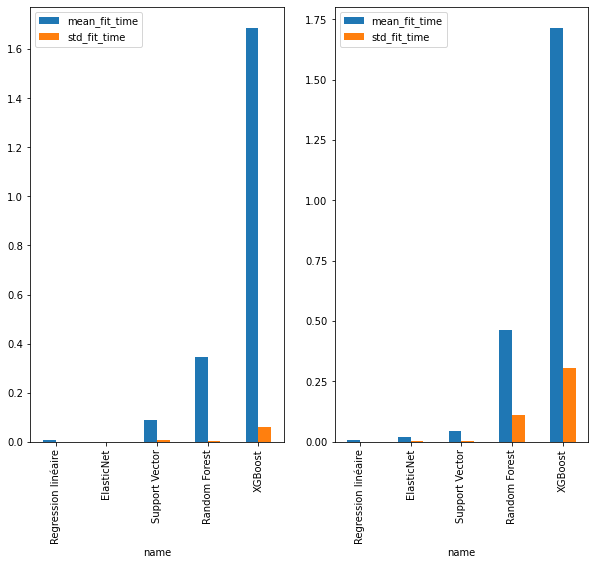

In [44]:
fig, axs = plt.subplots(1,2)
GHG_results[GHG_results['ESS']==True][['name','mean_fit_time','std_fit_time']].plot(x='name',kind='bar',figsize=(10,8),ax=axs[0])
GHG_results[GHG_results['ESS']==False][['name','mean_fit_time','std_fit_time']].plot(x='name',kind='bar',figsize=(10,8),ax=axs[1])


Le temps d'entraiment des modèles linéaire est superieur au celui des modèles linéaires cependant le modele xgboost est aussi beaucoup plus lent a entrainé que le RandomForest

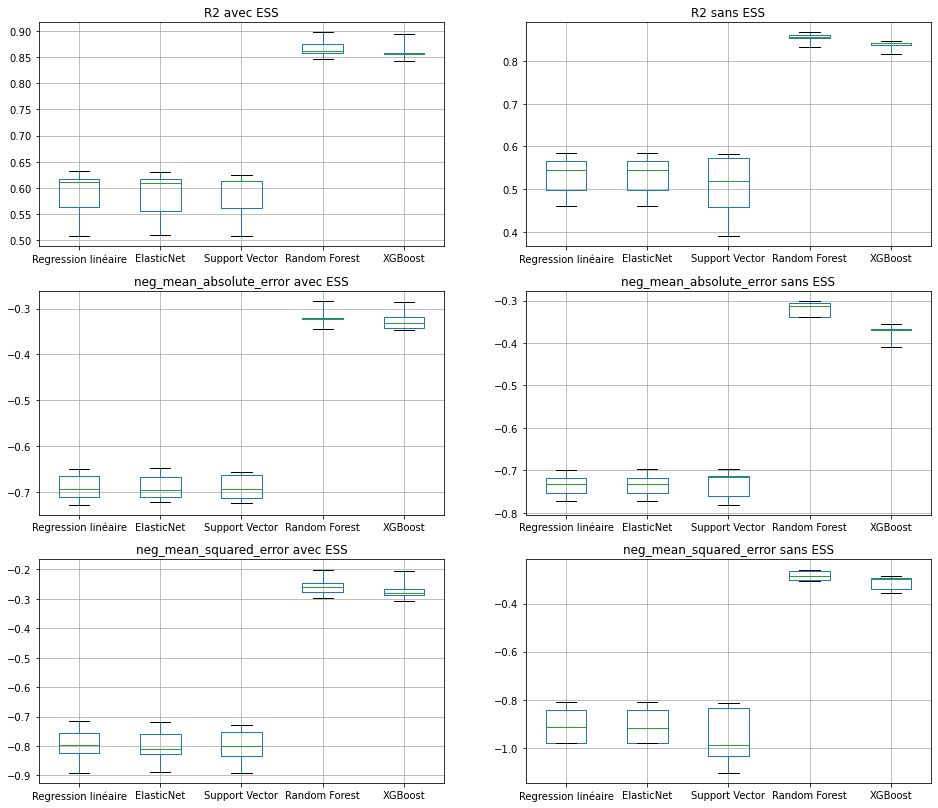

In [45]:

fig, axs = plt.subplots(3,2,figsize=(16,14))

box= GHG_results[GHG_results['ESS']==True].set_index('name').copy()
box[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].T.boxplot(ax=axs[0,0],whis=100)
box= GHG_results[GHG_results['ESS']==False].set_index('name').copy()
box[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].T.boxplot(ax=axs[0,1],whis=100)



box= GHG_results[GHG_results['ESS']==True].set_index('name').copy()
box[['split0_test_neg_mean_absolute_error','split1_test_neg_mean_absolute_error','split2_test_neg_mean_absolute_error','split3_test_neg_mean_absolute_error','split4_test_neg_mean_absolute_error']].T.boxplot(ax=axs[1,0],whis=1000)
box= GHG_results[GHG_results['ESS']==False].set_index('name').copy()
box[['split0_test_neg_mean_absolute_error','split1_test_neg_mean_absolute_error','split2_test_neg_mean_absolute_error','split3_test_neg_mean_absolute_error','split4_test_neg_mean_absolute_error']].T.boxplot(ax=axs[1,1],whis=1000)

box= GHG_results[GHG_results['ESS']==True].set_index('name').copy()
box[['split0_test_neg_mean_squared_error','split1_test_neg_mean_squared_error','split2_test_neg_mean_squared_error','split3_test_neg_mean_squared_error','split4_test_neg_mean_squared_error']].T.boxplot(ax=axs[2,0],whis=1000)
box= GHG_results[GHG_results['ESS']==False].set_index('name').copy()
box[['split0_test_neg_mean_squared_error','split1_test_neg_mean_squared_error','split2_test_neg_mean_squared_error','split3_test_neg_mean_squared_error','split4_test_neg_mean_squared_error']].T.boxplot(ax=axs[2,1],whis=1000)

axs[0, 0].set_title('R2 avec ESS')
axs[0, 1].set_title('R2 sans ESS')
axs[1, 0].set_title('neg_mean_absolute_error avec ESS')
axs[1, 1].set_title('neg_mean_absolute_error sans ESS')
axs[2, 0].set_title('neg_mean_squared_error avec ESS')
axs[2, 1].set_title('neg_mean_squared_error sans ESS')




Les modèles XGboost et RandomForest donne de bien meilleurs résultats pour nos métrique d'erreur.
On peut remarquer que la variable ENERGYSTARScore ammeliore legérement les perfomances du modèles XGBoost mais cela ne permet pas d'obtenir des meilleur scores que le modèle RandomForest

Text(0.5, 1.0, 'neg_mean_squared_error sans ESS')

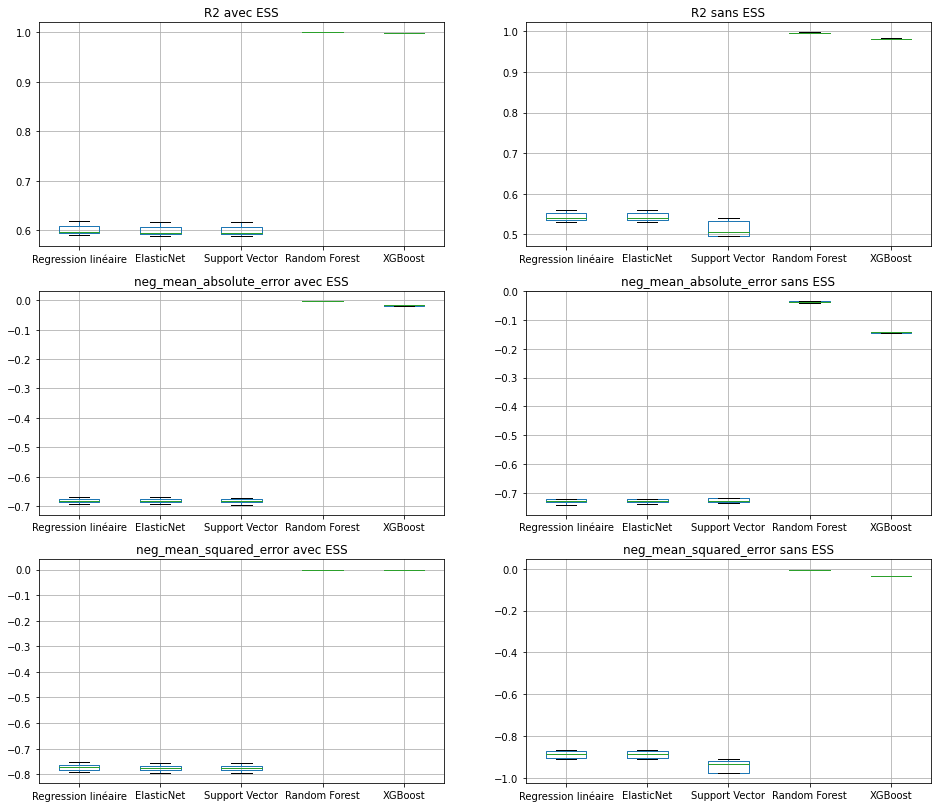

In [46]:
fig, axs = plt.subplots(3,2,figsize=(16,14))

box= GHG_results[GHG_results['ESS']==True].set_index('name').copy()
box[['split0_train_r2','split1_train_r2','split2_train_r2','split3_train_r2','split4_train_r2']].T.boxplot(ax=axs[0,0],whis=100)
box= GHG_results[GHG_results['ESS']==False].set_index('name').copy()
box[['split0_train_r2','split1_train_r2','split2_train_r2','split3_train_r2','split4_train_r2']].T.boxplot(ax=axs[0,1],whis=100)



box= GHG_results[GHG_results['ESS']==True].set_index('name').copy()
box[['split0_train_neg_mean_absolute_error','split1_train_neg_mean_absolute_error','split2_train_neg_mean_absolute_error','split3_train_neg_mean_absolute_error','split4_train_neg_mean_absolute_error']].T.boxplot(ax=axs[1,0],whis=100)
box= GHG_results[GHG_results['ESS']==False].set_index('name').copy()
box[['split0_train_neg_mean_absolute_error','split1_train_neg_mean_absolute_error','split2_train_neg_mean_absolute_error','split3_train_neg_mean_absolute_error','split4_train_neg_mean_absolute_error']].T.boxplot(ax=axs[1,1],whis=100)

box= GHG_results[GHG_results['ESS']==True].set_index('name').copy()
box[['split0_train_neg_mean_squared_error','split1_train_neg_mean_squared_error','split2_train_neg_mean_squared_error','split3_train_neg_mean_squared_error','split4_train_neg_mean_squared_error']].T.boxplot(ax=axs[2,0],whis=100)
box= GHG_results[GHG_results['ESS']==False].set_index('name').copy()
box[['split0_train_neg_mean_squared_error','split1_train_neg_mean_squared_error','split2_train_neg_mean_squared_error','split3_train_neg_mean_squared_error','split4_train_neg_mean_squared_error']].T.boxplot(ax=axs[2,1],whis=100)

axs[0, 0].set_title('R2 avec ESS')
axs[0, 1].set_title('R2 sans ESS')
axs[1, 0].set_title('neg_mean_absolute_error avec ESS')
axs[1, 1].set_title('neg_mean_absolute_error sans ESS')
axs[2, 0].set_title('neg_mean_squared_error avec ESS')
axs[2, 1].set_title('neg_mean_squared_error sans ESS')


Les résultats sont très similaires a ceux obtenue sur les jeux de test
Les modèles XGboost et RandomForest donne de bien meilleurs résultats pour nos métrique d'erreur.
On peut remarquer que la variable ENERGYSTARScore ammeliore legérement les perfomances du modèles XGBoost mais cela ne permet pas d'obtenir des meilleur scores que le modèle RandomForest

<AxesSubplot:xlabel='name'>

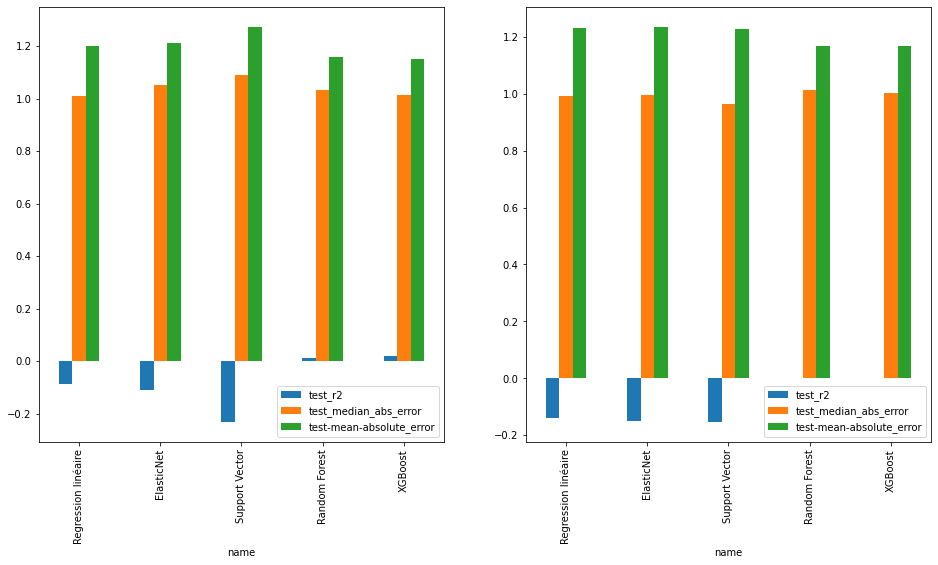

In [47]:
fig, axs = plt.subplots(figsize=(16,8),ncols=2)
GHG_test_results[GHG_test_results['ESS']==True].plot(x='name',kind='bar',ax=axs[0])
GHG_test_results[GHG_test_results['ESS']==False].plot(x='name',kind='bar',ax=axs[1])

Comme précedement les modèles XGBoost et RandomForest offrent de meilleur résultats .
La presence de lavariable ENERGYSTARScore améliore legerement les valeurs de la métrique R2

En conclusion les modèles RanfomForest et XgBoost on des performances similaires quand à la prédiction de la variable "TotalGHGEmissions" , cependant le modèle XGBoost étant beaucoup plus lent à entrainer , le modele RandomForest semble etre le meilleur choix

# Prediction EUI

Text(0.5, 1.0, 'sans ESS')

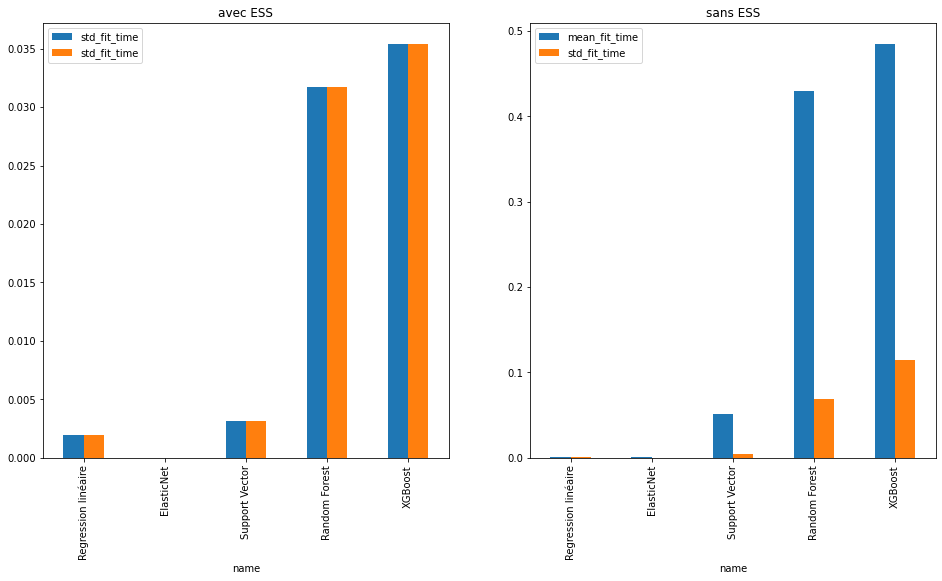

In [48]:
fig, axs = plt.subplots(figsize=(16,8),ncols=2)

EUI_results[EUI_results['ESS']==True][['name','std_fit_time','std_fit_time']].plot(x='name',kind='bar',ax=axs[0])
axs[0].set_title('avec ESS')

EUI_results[EUI_results['ESS']==False][['name','mean_fit_time','std_fit_time']].plot(x='name',kind='bar',ax=axs[1])
axs[1].set_title('sans ESS')

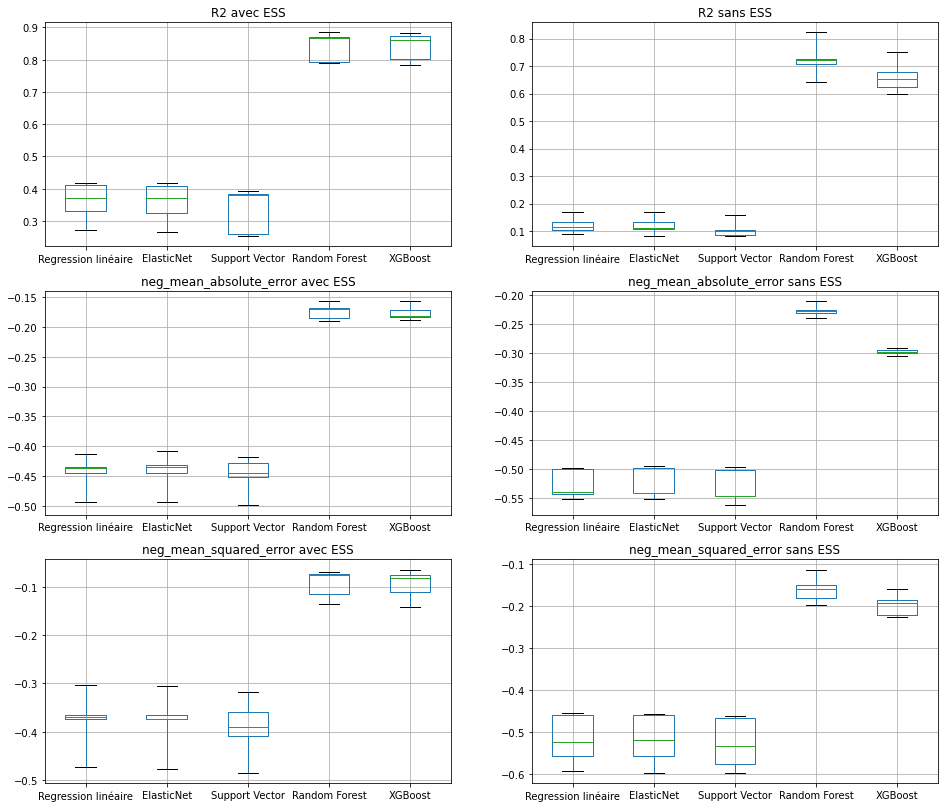

In [49]:


fig, axs = plt.subplots(3,2,figsize=(16,14))


box= EUI_results[EUI_results['ESS']==True].set_index('name').copy()
box[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].T.boxplot(ax=axs[0,0],whis=100)
box= EUI_results[EUI_results['ESS']==False].set_index('name').copy()
box[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].T.boxplot(ax=axs[0,1],whis=100)
    
box= EUI_results[EUI_results['ESS']==True].set_index('name').copy()
box[['split0_test_neg_mean_absolute_error','split1_test_neg_mean_absolute_error','split2_test_neg_mean_absolute_error','split3_test_neg_mean_absolute_error','split4_test_neg_mean_absolute_error']].T.boxplot(ax=axs[1,0],whis=100)
box= EUI_results[EUI_results['ESS']==False].set_index('name').copy()
box[['split0_test_neg_mean_absolute_error','split1_test_neg_mean_absolute_error','split2_test_neg_mean_absolute_error','split3_test_neg_mean_absolute_error','split4_test_neg_mean_absolute_error']].T.boxplot(ax=axs[1,1],whis=100)

box= EUI_results[EUI_results['ESS']==True].set_index('name').copy()
box[['split0_test_neg_mean_squared_error','split1_test_neg_mean_squared_error','split2_test_neg_mean_squared_error','split3_test_neg_mean_squared_error','split4_test_neg_mean_squared_error']].T.boxplot(ax=axs[2,0],whis=100)
box= EUI_results[EUI_results['ESS']==False].set_index('name').copy()
box[['split0_test_neg_mean_squared_error','split1_test_neg_mean_squared_error','split2_test_neg_mean_squared_error','split3_test_neg_mean_squared_error','split4_test_neg_mean_squared_error']].T.boxplot(ax=axs[2,1],whis=100)

axs[0, 0].set_title('R2 avec ESS')
axs[0, 1].set_title('R2 sans ESS')
axs[1, 0].set_title('neg_mean_absolute_error avec ESS')
axs[1, 1].set_title('neg_mean_absolute_error sans ESS')
axs[2, 0].set_title('neg_mean_squared_error avec ESS')
axs[2, 1].set_title('neg_mean_squared_error sans ESS')



Text(0.5, 1.0, 'neg_mean_squared_error sans ESS')

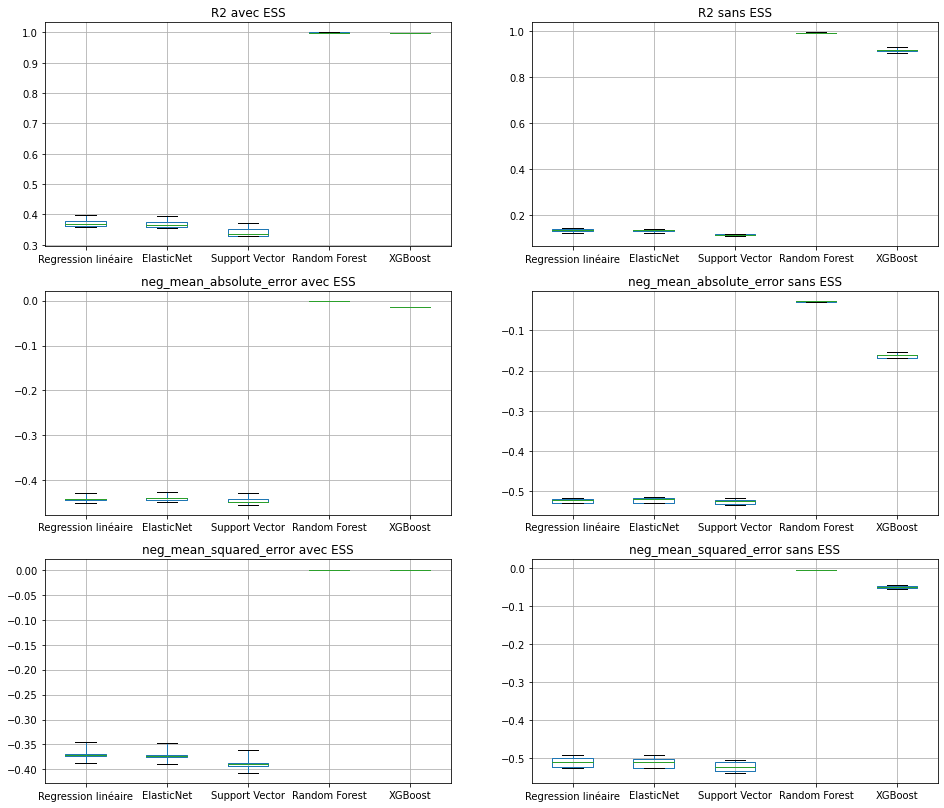

In [50]:
fig, axs = plt.subplots(3,2,figsize=(16,14))

box= EUI_results[EUI_results['ESS']==True].set_index('name').copy()
box[['split0_train_r2','split1_train_r2','split2_train_r2','split3_train_r2','split4_train_r2']].T.boxplot(ax=axs[0,0],whis=100)
box= EUI_results[EUI_results['ESS']==False].set_index('name').copy()
box[['split0_train_r2','split1_train_r2','split2_train_r2','split3_train_r2','split4_train_r2']].T.boxplot(ax=axs[0,1],whis=100)



box= EUI_results[EUI_results['ESS']==True].set_index('name').copy()
box[['split0_train_neg_mean_absolute_error','split1_train_neg_mean_absolute_error','split2_train_neg_mean_absolute_error','split3_train_neg_mean_absolute_error','split4_train_neg_mean_absolute_error']].T.boxplot(ax=axs[1,0],whis=100)
box= EUI_results[EUI_results['ESS']==False].set_index('name').copy()
box[['split0_train_neg_mean_absolute_error','split1_train_neg_mean_absolute_error','split2_train_neg_mean_absolute_error','split3_train_neg_mean_absolute_error','split4_train_neg_mean_absolute_error']].T.boxplot(ax=axs[1,1],whis=100)

box= EUI_results[EUI_results['ESS']==True].set_index('name').copy()
box[['split0_train_neg_mean_squared_error','split1_train_neg_mean_squared_error','split2_train_neg_mean_squared_error','split3_train_neg_mean_squared_error','split4_train_neg_mean_squared_error']].T.boxplot(ax=axs[2,0],whis=100)
box= EUI_results[EUI_results['ESS']==False].set_index('name').copy()
box[['split0_train_neg_mean_squared_error','split1_train_neg_mean_squared_error','split2_train_neg_mean_squared_error','split3_train_neg_mean_squared_error','split4_train_neg_mean_squared_error']].T.boxplot(ax=axs[2,1],whis=100)

axs[0, 0].set_title('R2 avec ESS')
axs[0, 1].set_title('R2 sans ESS')
axs[1, 0].set_title('neg_mean_absolute_error avec ESS')
axs[1, 1].set_title('neg_mean_absolute_error sans ESS')
axs[2, 0].set_title('neg_mean_squared_error avec ESS')
axs[2, 1].set_title('neg_mean_squared_error sans ESS')


<AxesSubplot:xlabel='name'>

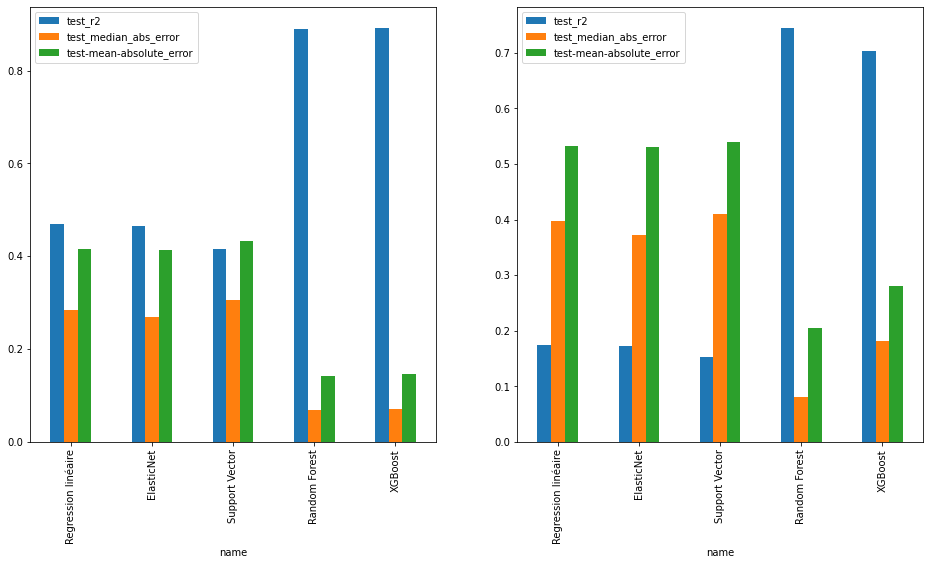

In [51]:
fig, axs = plt.subplots(figsize=(16,8),ncols=2)
EUI_test_results[EUI_test_results['ESS']==True].plot(x='name',kind='bar',ax=axs[0])
EUI_test_results[EUI_test_results['ESS']==False].plot(x='name',kind='bar',ax=axs[1])

Avec la variable ENERGYSTARScore on tombe a des résultats qui sont plus précis que ceux obtenue lors de la prédiction de la variable "TotalGHGEmissions"
De plus comme précedement le deux modèles XGBoost et RandomForest on des résultats très similaires cependant le modèle de forêt aléatoire étant bien moin long à entrainer, nous le prefererons aux XGBoost

In [52]:
X_train

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),SecondLargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),NaturalGas(kBtu)
1050,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,3,EAST,1920,3.0,7807.333333,100.000000,SMALL- AND MID-SIZED OFFICE,64.0,0,1
1967,NONRESIDENTIAL,WAREHOUSE,2,GREATER DUWAMISH,1926,2.0,10200.000000,100.000000,OFFICE,69.0,0,1
1387,NONRESIDENTIAL,LARGE OFFICE,2,DOWNTOWN,2002,10.0,18169.400000,78.983346,PARKING,88.0,0,0
1639,NONRESIDENTIAL,HOTEL,4,NORTHEAST,1930,3.0,6857.000000,100.000000,HOTEL,72.0,0,0
1652,NONRESIDENTIAL,K-12 SCHOOL,1,SOUTHWEST,1922,2.0,16731.000000,100.000000,K-12 SCHOOL,76.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1638,NONRESIDENTIAL,RETAIL STORE,4,NORTHEAST,1900,3.0,10986.666667,100.000000,RETAIL STORE,71.0,0,0
1095,NONRESIDENTIAL,MIXED USE PROPERTY,7,DOWNTOWN,1902,6.0,12368.500000,100.000000,MULTIFAMILY HOUSING,97.0,0,0
1130,SPS-DISTRICT K-12,K-12 SCHOOL,2,SOUTHEAST,1961,2.0,28114.000000,100.000000,K-12 SCHOOL,95.0,0,1
1294,NONRESIDENTIAL,LARGE OFFICE,7,DOWNTOWN,1964,22.0,15287.727273,100.000000,PARKING,77.0,1,1


# Etude meilleur modele GHG

Nous avons vu que notre meilleur modèle pour la prédiction de cette variable est le RandomForest, nous allons maintenant observer en detail ce modèle et regarder :
    - L'évolution des scores en fonction des hyperparametre
    - Le Feature importance du modèle
    

In [53]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
             }

In [54]:
#Fonction d'affichage des scores de GridSearch pour chacun des paramètres
def plot_search_results(grid, title): 
       
    ## Résultats de la GridSearch
    results = grid.cv_results_
    means_test = results['mean_test_neg_mean_absolute_error']
    stds_test = results['std_test_neg_mean_absolute_error']
    means_train = results['mean_train_neg_mean_absolute_error']
    stds_train = results['std_train_neg_mean_absolute_error']
    

    ## Index de valeurs par hyper-paramètre
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    
    ## Plot des résultats
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Scores par paramètres pour la variable {}'.format(title), 
                 fontdict=font_title, fontsize=22)
    fig.text(0.04, 0.5, 'NEG MEAN ABSOLUTE ERROR SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test', color="#2cb7b0")
        ax[i].errorbar(x, y_2, e_2, linestyle='--', marker='o', label='train', color="#337da4")
        ax[i].set_xlabel(p.upper())

    plt.legend()

    plt.show()
    
    print("\nRappel des meilleurs paramètres :\n{}".format(grid.best_params_))

In [55]:
X.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'SecondLargestPropertyUseType',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'NaturalGas(kBtu)'],
      dtype='object')

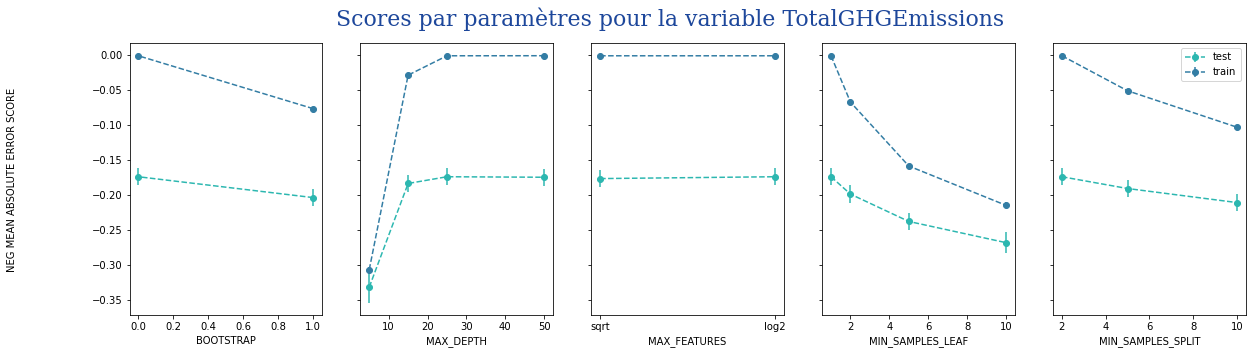


Rappel des meilleurs paramètres :
{'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [56]:
plot_search_results(GHG_rfr_model.named_steps['grid_search_rfr'], title="TotalGHGEmissions")


In [57]:

#Récuperation des SHAP values pour le modèle EUI_rfr_model
feature_names = X.columns
result = permutation_importance(
    GHG_rfr_model, X_test, Y_test["TotalGHGEmissions"], n_repeats=10, random_state=42, n_jobs=2
)



forest_importances = pd.Series(result.importances_mean, index=feature_names)

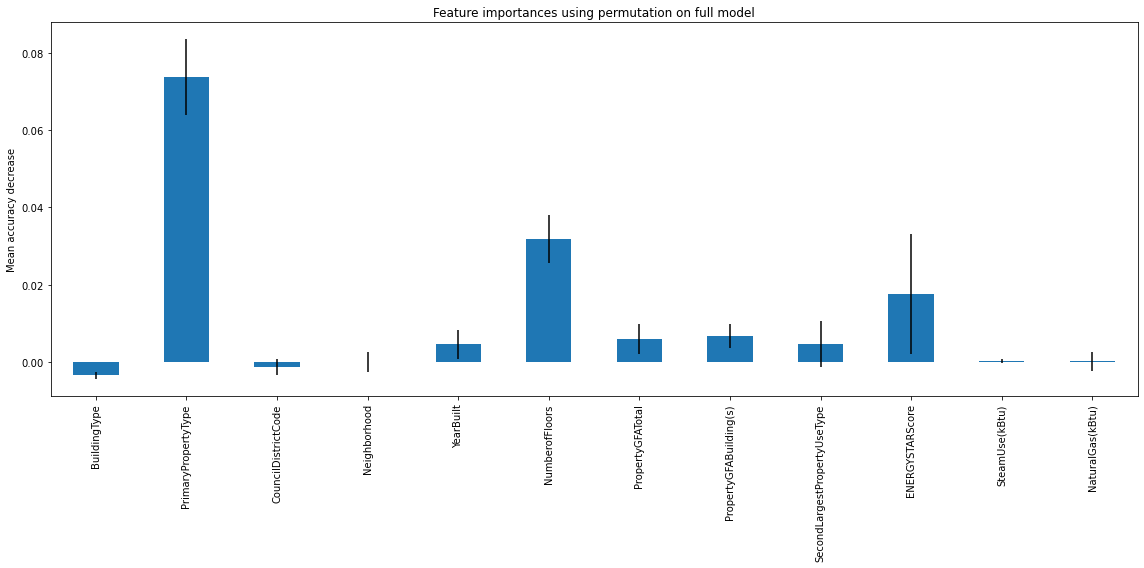

In [58]:
fig, ax = plt.subplots(figsize=(16,8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


La variable PrimaryPropertyType est de loin la variable la plus importantes pour le modèles , la variable ENERGYSTARScore arrive seulement en 3eme place mble avoir des résultats qui veen sarie en lors des permutations

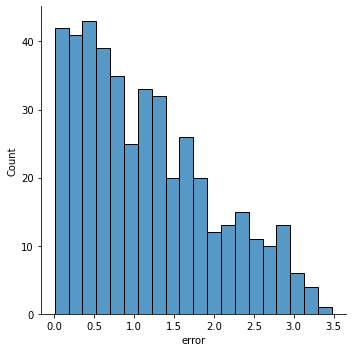

In [59]:

result=X_test.copy()
result['result']=GHG_rfr_model.predict(X_test)
result['error']=abs(Y_test["TotalGHGEmissions"]-result['result'])
sns.displot(x='error',data=result,bins=20)


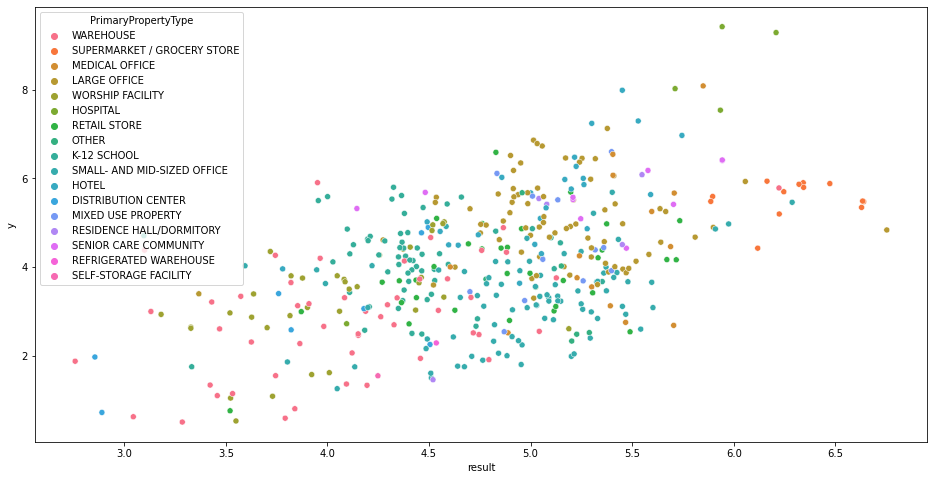

In [60]:
result['y']=Y_test["TotalGHGEmissions"]
plt.figure(figsize=(16,8))
sns.scatterplot(x='result',y="y",data=result,hue='PrimaryPropertyType',)


On peut voir que nos données ne sont pas concentré près de la premiere bissectrice, ce qui pose des questions sur la précision du modèles

In [61]:
X_test

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),SecondLargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),NaturalGas(kBtu)
1966,NONRESIDENTIAL,WAREHOUSE,2,GREATER DUWAMISH,1992,1.0,29394.000000,100.000000,OFFICE,60.0,0,1
1091,NONRESIDENTIAL,SUPERMARKET / GROCERY STORE,5,NORTH,2011,1.0,51400.000000,100.000000,PARKING,75.0,0,1
1468,NONRESIDENTIAL,MEDICAL OFFICE,3,EAST,1985,10.0,42250.300000,51.105673,MEDICAL OFFICE,46.0,1,0
438,NONRESIDENTIAL,LARGE OFFICE,7,DOWNTOWN,1971,9.0,24984.111111,100.000000,LARGE OFFICE,73.0,1,0
1790,NONRESIDENTIAL,WORSHIP FACILITY,5,NORTHWEST,1962,1.0,22047.000000,100.000000,PARKING,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1973,19.0,17477.210526,82.148181,HOTEL,6.0,1,1
930,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,2,SOUTHEAST,1967,2.0,11625.000000,100.000000,SMALL- AND MID-SIZED OFFICE,51.0,0,0
1735,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,7,DOWNTOWN,1907,6.0,5866.666667,100.000000,SMALL- AND MID-SIZED OFFICE,8.0,0,0
59,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,3,SOUTHEAST,2003,3.0,33144.333333,64.044130,PARKING,71.0,0,0


In [62]:
X_test

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),SecondLargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),NaturalGas(kBtu)
1966,NONRESIDENTIAL,WAREHOUSE,2,GREATER DUWAMISH,1992,1.0,29394.000000,100.000000,OFFICE,60.0,0,1
1091,NONRESIDENTIAL,SUPERMARKET / GROCERY STORE,5,NORTH,2011,1.0,51400.000000,100.000000,PARKING,75.0,0,1
1468,NONRESIDENTIAL,MEDICAL OFFICE,3,EAST,1985,10.0,42250.300000,51.105673,MEDICAL OFFICE,46.0,1,0
438,NONRESIDENTIAL,LARGE OFFICE,7,DOWNTOWN,1971,9.0,24984.111111,100.000000,LARGE OFFICE,73.0,1,0
1790,NONRESIDENTIAL,WORSHIP FACILITY,5,NORTHWEST,1962,1.0,22047.000000,100.000000,PARKING,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,NONRESIDENTIAL,HOTEL,7,DOWNTOWN,1973,19.0,17477.210526,82.148181,HOTEL,6.0,1,1
930,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,2,SOUTHEAST,1967,2.0,11625.000000,100.000000,SMALL- AND MID-SIZED OFFICE,51.0,0,0
1735,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,7,DOWNTOWN,1907,6.0,5866.666667,100.000000,SMALL- AND MID-SIZED OFFICE,8.0,0,0
59,NONRESIDENTIAL,SMALL- AND MID-SIZED OFFICE,3,SOUTHEAST,2003,3.0,33144.333333,64.044130,PARKING,71.0,0,0


On se demander si l'importance de la variable ENERGYSTARScore dans le modèle depend d'autre variable , notamment la plus importantes :'PrimaryPropertyType'.
Pour cela ont calculera la valeurs de SHAP de notre modèles et on affichera :
- Le summary plot du modèles
- Le dépendance plot des variables ENERGYSTARScore et PrimaryPropertyType

In [63]:
data_transformation = pd.DataFrame(rfr_grid_cv.named_steps['preprocessor'].transform(X_test),columns=ordinal+numeric+binar )

Using 441 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/441 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.185e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.664e-03, with an active set of 6 regressors

Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.933e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.933e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.391e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.196e-02, with an active set of 2 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.207e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.536e-02, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.165e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.082e-02, with an active set of 3 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.925e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.463e-03, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.156e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.156e-03, with an active set of 3 regressors

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.600e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.250e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.134e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.784e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.488e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.244e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.244e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.236e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.281e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.153e-03, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.774e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.774e-05, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.695e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.695e-03, with an active set of 6 regressors

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.494e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.494e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.423e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.423e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
The default of 'normalize' will be set to False 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.637e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.637e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.318e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.318e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.002e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.501e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.501e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.528e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
The default of 'normalize' will be set to False 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.140e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.700e-04, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.455e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.851e-04, with an active set of 7 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.275e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.275e-02, with an active set of 4 regressors

Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.373e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.186e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.184e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.183e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.162e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.826e-04, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.046e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.025e-04, with an active set of 7 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.299e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.988e-04, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.119e-04, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.735e-04, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.104e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.874e-03, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.816e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.122e-03, with an active set of 3 regressors

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.165e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.884e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.794e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.692e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.837e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.707e-03, with an active set of 3 regressors

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.428e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.714e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.699e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.686e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.197e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.197e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.105e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.048e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
The default of 'normalize' will be set to False 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.293e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.147e-02, with an active set of 5 regressors

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.487e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.744e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.744e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.164e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.185e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.181e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.150e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.149e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
The default of 'normalize' will be set to False 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.013e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.521e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.110e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.810e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.054e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.688e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.688e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.678e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.075e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.037e-05, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.417e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.086e-03, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.252e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.126e-03, with an active set of 6 regressor

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.288e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.678e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.610e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.026e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.723e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.853e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.853e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.026e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.565e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.271e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.788e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.788e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues ar

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.786e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.931e-03, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.001e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.056e-03, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.439e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.165e-02, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.705e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.277e-02, with an active set of 3 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.921e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.404e-05, with an active set of 7 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.135e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.824e-02, with an active set of 2 regressors

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.614e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.807e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.795e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.666e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.273e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.365e-03, with an active set of 4 regressors

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.511e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.486e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.486e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.797e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.049e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.831e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.831e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.550e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.734e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.279e-03, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.606e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.303e-02, with an active set of 3 regressors

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.205e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.311e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.832e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.313e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.299e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.649e-04, with an active set of 5 regressors

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.703e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.721e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.158e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.607e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues ar

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.618e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.519e-03, with an active set of 3 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.402e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.649e-03, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.498e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.835e-04, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.156e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.078e-03, with an active set of 3 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.387e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.975e-03, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.267e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.134e-02, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.943e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.699e-03, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.452e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.254e-04, with an active set of 5 regressors

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.838e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.191e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.975e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.595e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.640e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.718e-03, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.435e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.176e-03, with an active set of 4 regressors

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.021e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.106e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.106e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.452e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.797e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.898e-03, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.223e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.092e-03, with an active set of 3 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.336e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.668e-03, with an active set of 4 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.805e-05, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.698e-05, with an active set of 6 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.534e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.671e-03, with an active set of 2 regressors

Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.032e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.032e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.015e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.015e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.920e-04, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.664e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.664e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.271e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.016e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.093e-02, with an active set of 3 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.539e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.240e-03, with an active set of 6 regressors

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.333e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.663e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.330e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.204e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.895e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.448e-04, with an active set of 5 regressors

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.144e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.572e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.467e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.892e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

<Figure size 432x288 with 0 Axes>

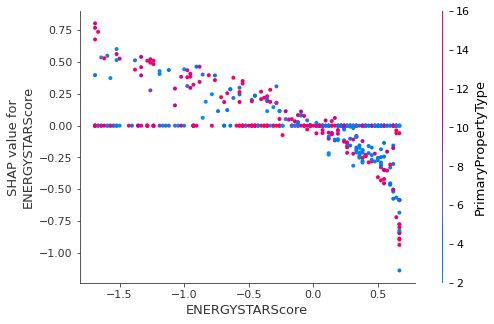

In [64]:
#Récuperation de valeurs SHAP du modele
plt.figure()
explainer = shap.KernelExplainer(GHG_rfr_model.named_steps["grid_search_rfr"].predict,data_transformation,feature_names=feature_names)
shap_value=explainer.shap_values(data_transformation,nsamples=100)
shap.dependence_plot("ENERGYSTARScore",shap_value, data_transformation,interaction_index=2,show=False)


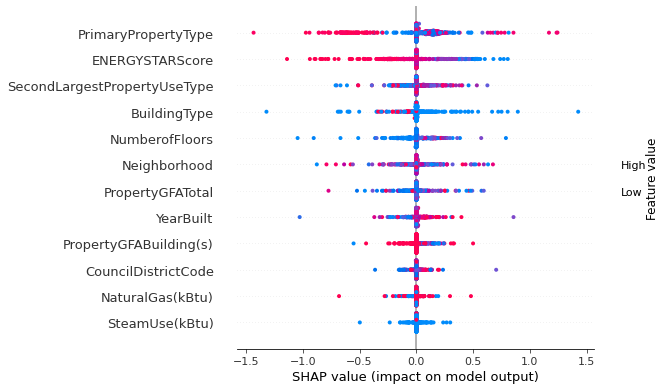

In [65]:
shap.summary_plot(shap_value,data_transformation,show=False)


# Etude meilleur modele EUI

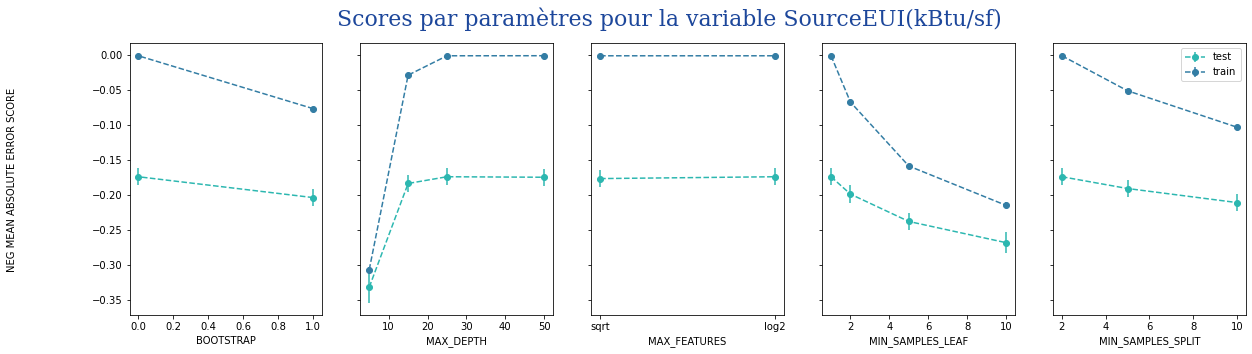


Rappel des meilleurs paramètres :
{'bootstrap': False, 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [66]:
plot_search_results(EUI_rfr_model.named_steps['grid_search_rfr'], title="SourceEUI(kBtu/sf)")


L'évolution des résultats selon les hyperparamètres est exactement la meme que pour la variable TotalGHGEmission

In [67]:
#Récuperation des SHAP values pour le modèle EUI_rfr_model
result = permutation_importance(
    EUI_rfr_model, X_test, Y_test["SourceEUI(kBtu/sf)"], n_repeats=11, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

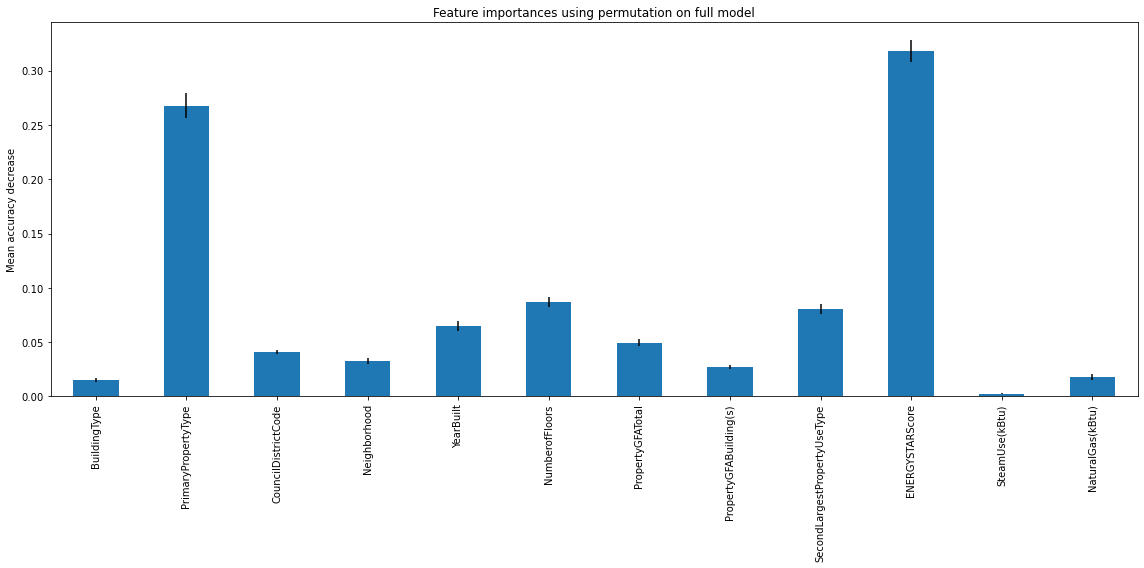

In [68]:
fig, ax = plt.subplots(figsize=(16,8))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


Les variables ENERGYSTARScore et PrimaryPropertyType sont les plus importantes pour le modèle , cependant pour cette target le modèle accorde de l'importance a toute les variables du DataFrame

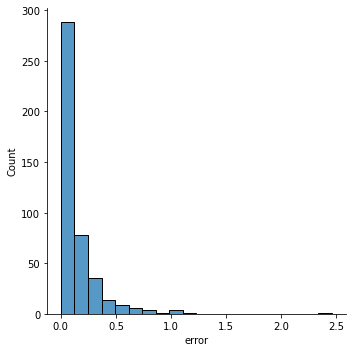

In [69]:
result=X_test.copy()
result['result']=EUI_xgb_model.predict(X_test)
result['error']=abs(Y_test["SourceEUI(kBtu/sf)"]-result['result'])
sns.displot(x='error',data=result,bins=20)


In [ ]:
result['y']=Y_test["SourceEUI(kBtu/sf)"]
plt.figure(figsize=(16,8))
sns.scatterplot(x='result',y="y",data=result,hue='PrimaryPropertyType',)


Toute nos erreur sont inférieur à 1 et concentré autour de zero, de plus on peut voir que les résultats sont bien regroupé autour de la première bissetrice, la prediction de la variable SourceEUI est donc plus précise que celle de la variable TotalGHEEmission

# Conclusion

Le modèle de RandomForest est le meilleur modèle pour la prediction des deux variables, cependant si les prédictions de la variable SourceEUI sont précises , celles des emissions donne des résultats très éloigné de la bissectrices et ne semble donc pas optimal.
La variable ENERGYSTARScore n'apporte que très peu de précision lors de la prédiction des emissions et au vu de sa difficulté d'obtention, ne semble pas etre un investissement pertinent pour prédire cette donnée.

